1. id	(continous)	Unique identifier for the Customer.
2. Age	(continous)	Age of the Customer.
3. Gender	(dichotomous)	Gender of the Customer.
4. Driving_License	(dichotomous)	0 for customer not having DL, 1 for customer having DL.
5. Region_Code	(nominal)	Unique code for the region of the customer.
6. Previously_Insured	(dichotomous)	0 for customer not having vehicle insurance, 1 for customer having vehicle insurance.
7. Vehicle_Age	(nominal)	Age of the vehicle.
8. Vehicle_Damage	(dichotomous)	Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
9. Annual_Premium	(continous)	The amount customer needs to pay as premium in the year.
10. Policy_Sales_Channel	(nominal)	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
11. Vintage	(continous)	Number of Days, Customer has been associated with the company.
12. Response (Dependent Feature)	(dichotomous)	1 for Customer is interested, 0 for Customer is not interested.

# Setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Load

In [2]:
train = pd.DataFrame(pd.read_csv("data\\train.csv"))
test = pd.DataFrame(pd.read_csv("data\\test.csv"))

# EDA

## Check Data Distribution

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11504798.0,5.752398e+06,3.321149e+06,0.0,2876199.25,5752398.5,8628597.75,11504797.0
Age,11504798.0,3.838356e+01,1.499346e+01,20.0,24.00,36.0,49.00,85.0
Driving_License,11504798.0,9.980220e-01,4.443120e-02,0.0,1.00,1.0,1.00,1.0
Region_Code,11504798.0,2.641869e+01,1.299159e+01,0.0,15.00,28.0,35.00,52.0
Previously_Insured,11504798.0,4.629966e-01,4.986289e-01,0.0,0.00,0.0,1.00,1.0
Annual_Premium,11504798.0,3.046137e+04,1.645475e+04,2630.0,25277.00,31824.0,39451.00,540165.0
Policy_Sales_Channel,11504798.0,1.124254e+02,5.403571e+01,1.0,29.00,151.0,152.00,163.0
Vintage,11504798.0,1.638977e+02,7.997953e+01,10.0,99.00,166.0,232.00,299.0
Response,11504798.0,1.229973e-01,3.284341e-01,0.0,0.00,0.0,0.00,1.0


In [5]:
# Define column
less = []
for i in train.columns[1:]:
    if train[i].nunique() < 10:
        less.append(i)
        
print('Column have LESS than 10 unique values: ', less)
print('Column have MORE than 10 unique values: ', [i for i in train.columns if i not in less])

Column have LESS than 10 unique values:  ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']
Column have MORE than 10 unique values:  ['id', 'Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']


## Type Change to Categorical columns for faster analysis

In [6]:
# Change to categorical columns for faster analysis:
for i in less:
    train[i] = train[i].astype('category')
    
from pandas.api.types import CategoricalDtype

# Define the new order of categories
new_categories = ['< 1 Year', '1-2 Year', '> 2 Years']

# Create a new CategoricalDtype with the desired order
new_dtype = CategoricalDtype(categories=new_categories, ordered=True)

# Update the 'Vehicle_Age' column with the new dtype
train['Vehicle_Age'] = train['Vehicle_Age'].astype(new_dtype)

In [7]:
train['Gender'].value_counts()

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

In [8]:
train['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

In [9]:
train['Response'].value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

## Visualization

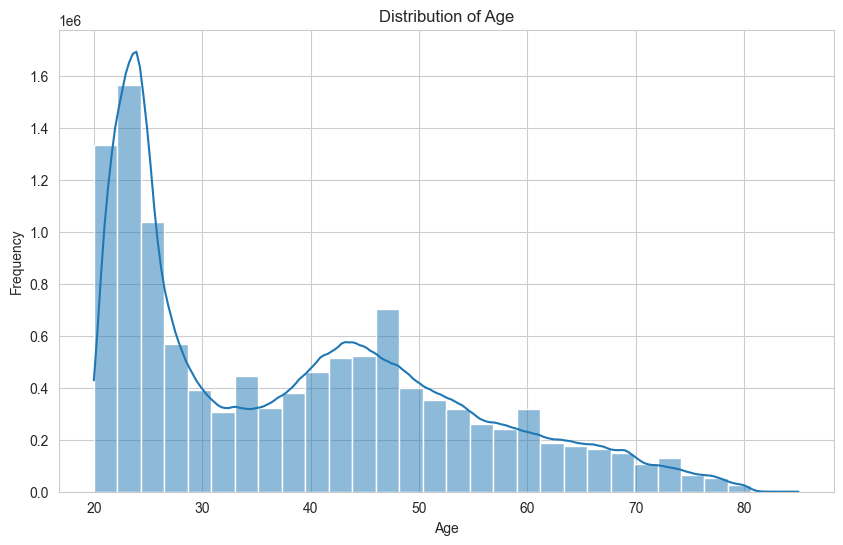

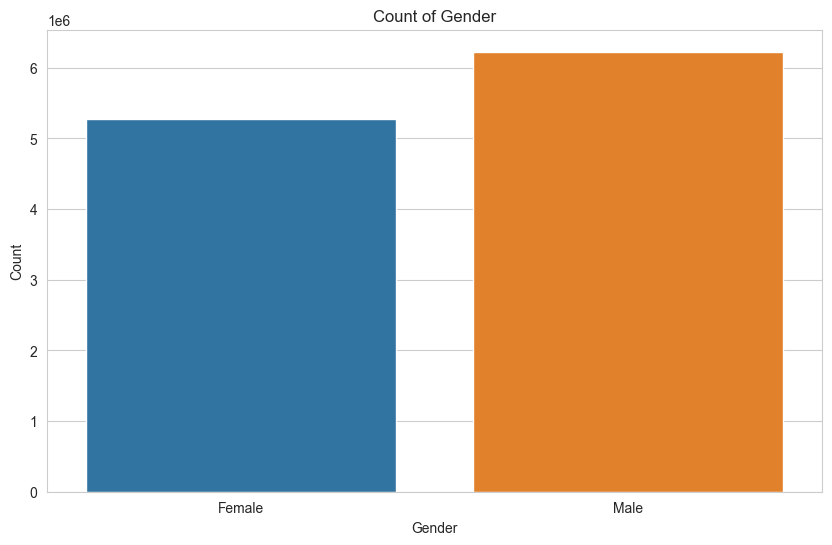

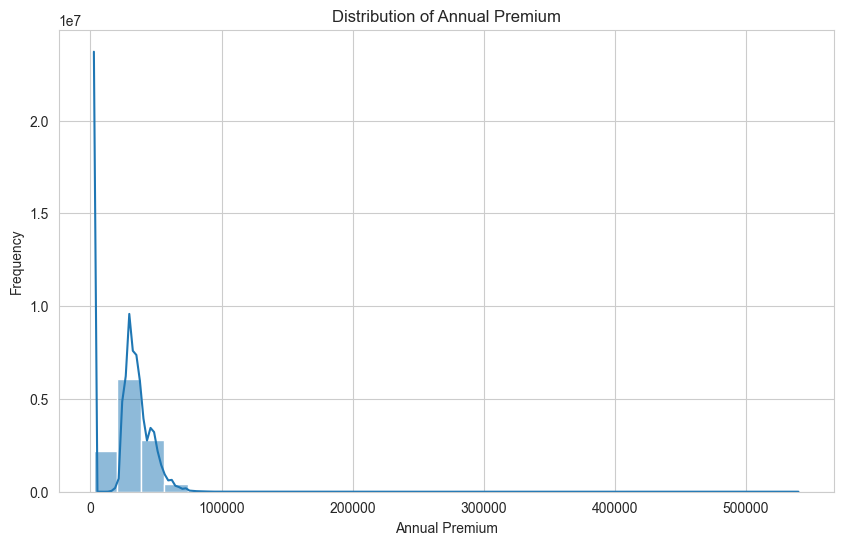

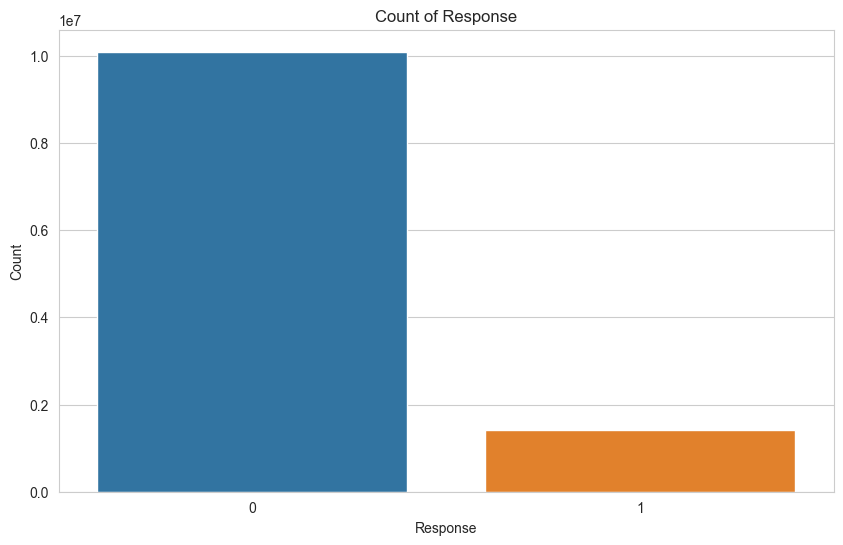

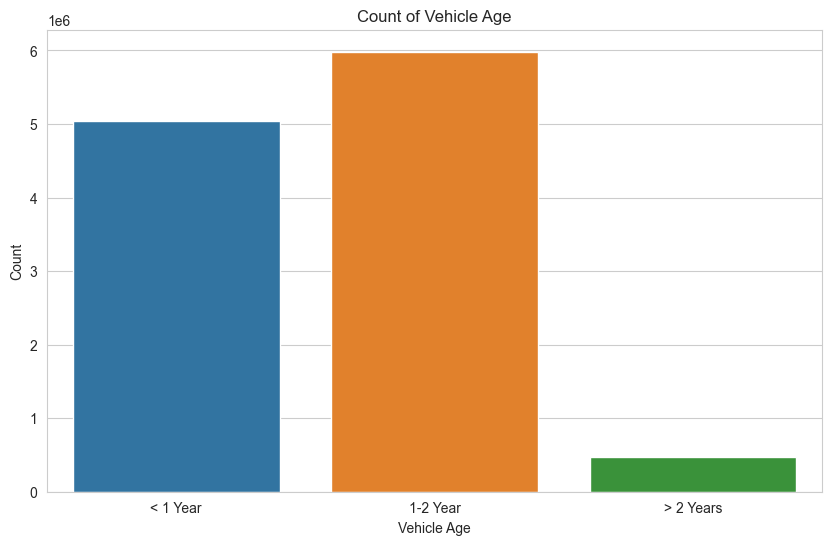

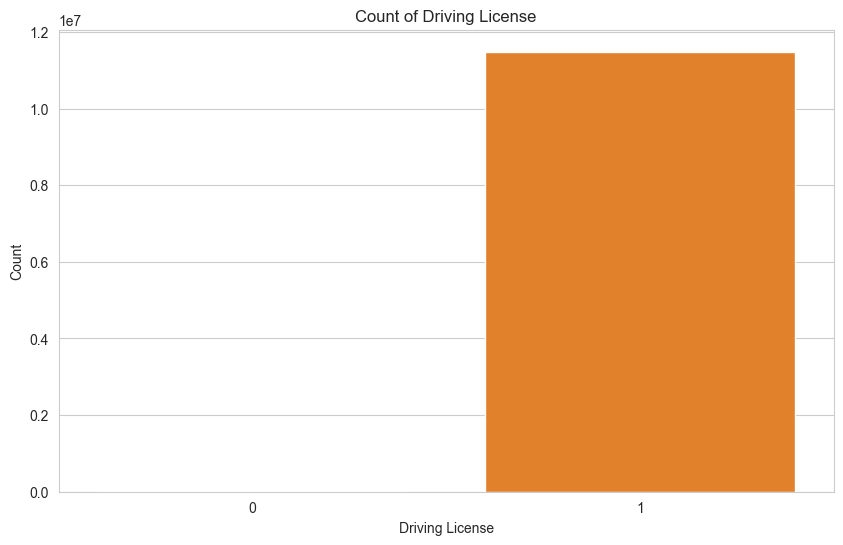

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Plot the count of 'Gender'
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', data=train)
plt.title('Count of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Plot the distribution of 'Annual_Premium'
plt.figure(figsize=(10, 6))
sns.histplot(train['Annual_Premium'], bins=30, kde=True)
plt.title('Distribution of Annual Premium')
plt.xlabel('Annual Premium')
plt.ylabel('Frequency')
plt.show()

# Plot the count of 'Response'
plt.figure(figsize=(10, 6))
sns.countplot(x='Response', data=train)
plt.title('Count of Response')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

# Plot the count of 'Vehicle_Age'
plt.figure(figsize=(10, 6))
sns.countplot(x='Vehicle_Age', data=train)
plt.title('Count of Vehicle Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.show()

# Plot the count of 'Driving_License'
plt.figure(figsize=(10, 6))
sns.countplot(x='Driving_License', data=train)
plt.title('Count of Driving License')
plt.xlabel('Driving License')
plt.ylabel('Count')
plt.show()


- Imbalance of Class Data -> '_Response_' column
    - **0** (Not Response): **10,089,739**
    - **1** (Response): **1,415,059**

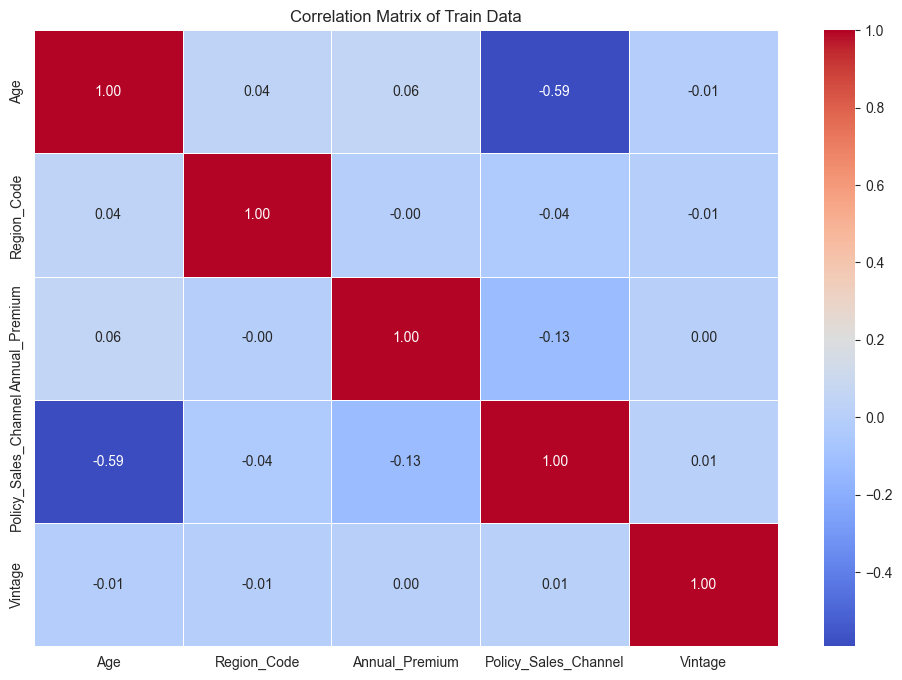

In [12]:
# 숫자(int, float) 타입이 아닌 컬럼을 제외하고 correlation matrix를 계산
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train[numeric_columns].drop(columns=['id']).corr()

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Train Data')
plt.show()

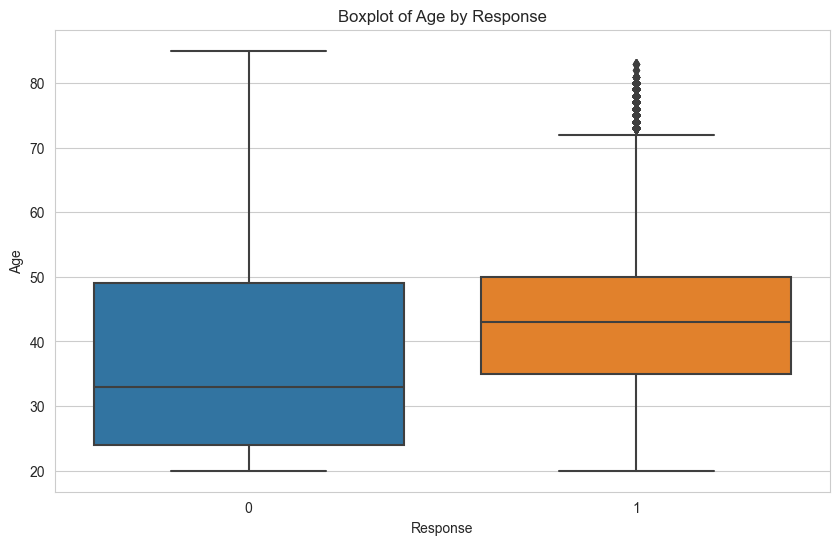

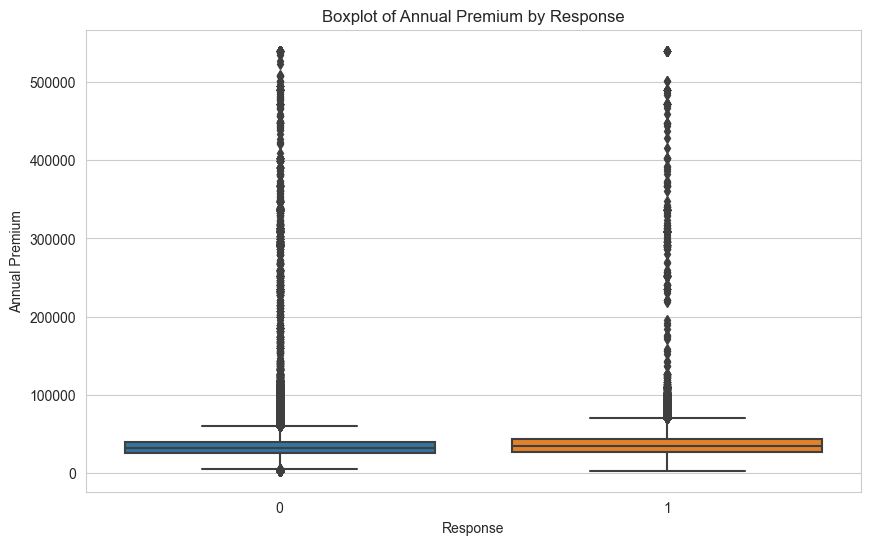

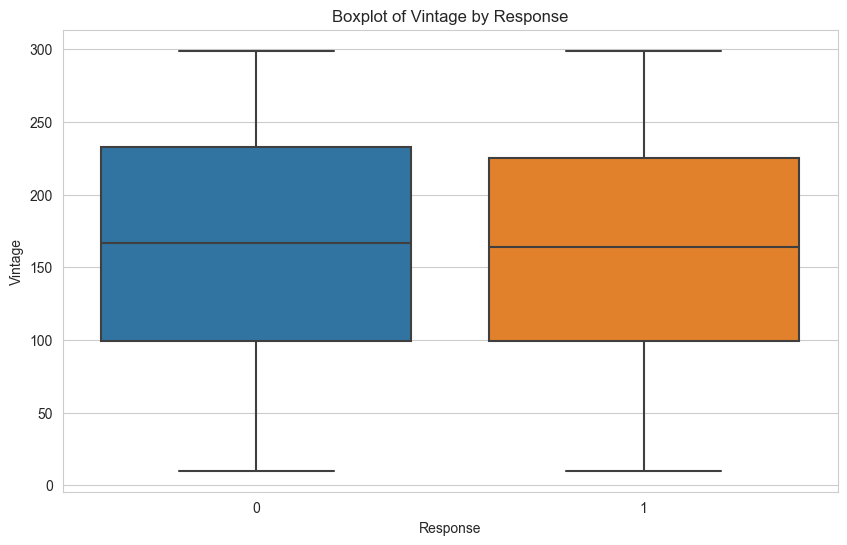

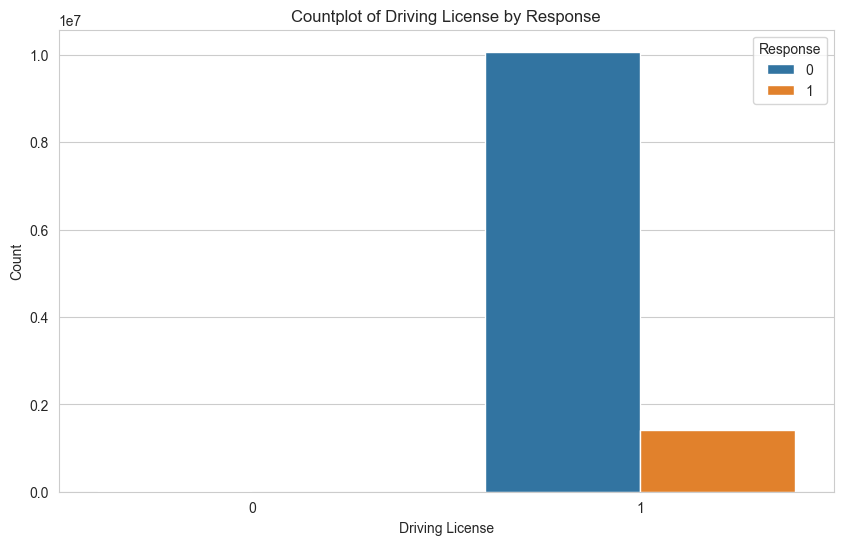

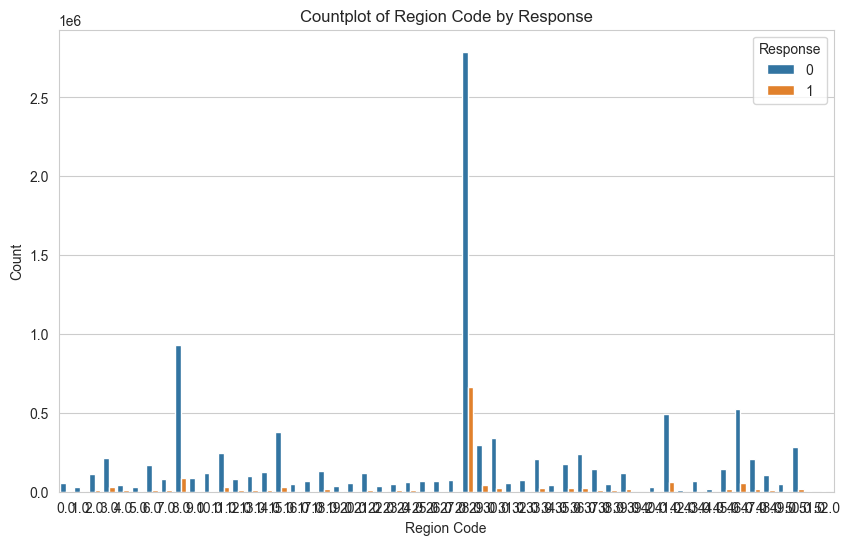

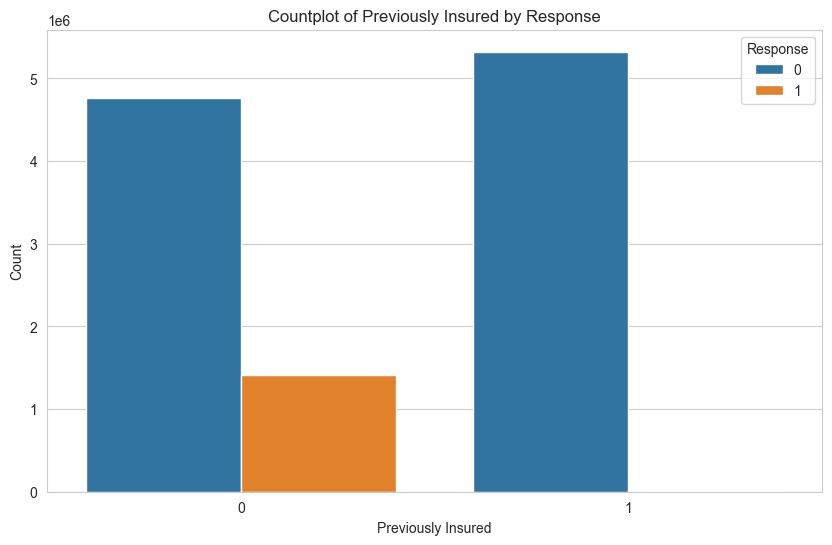

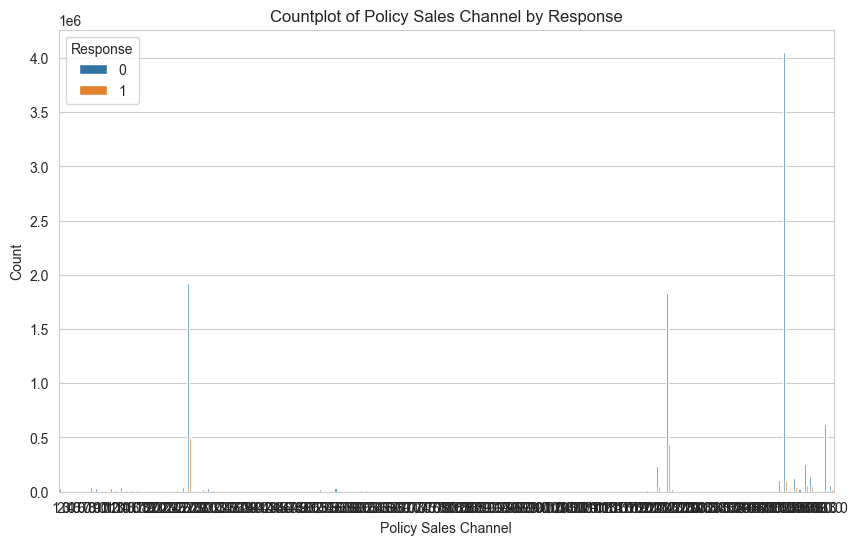

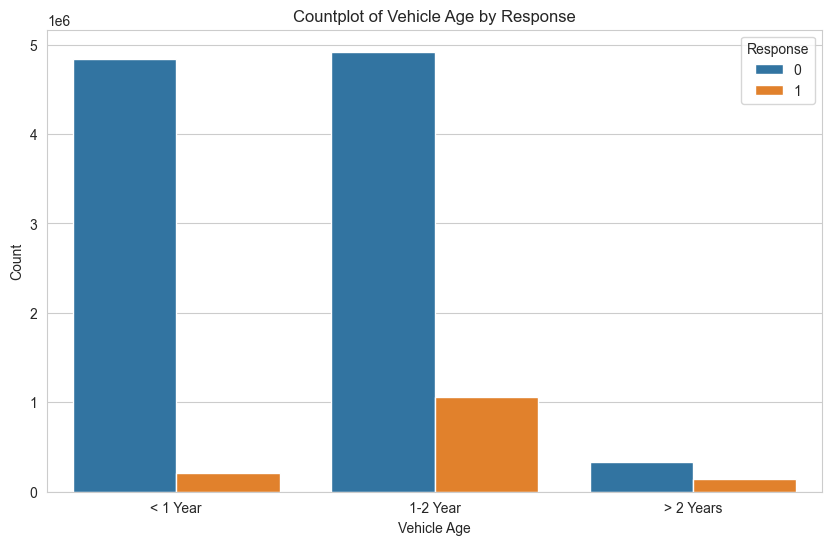

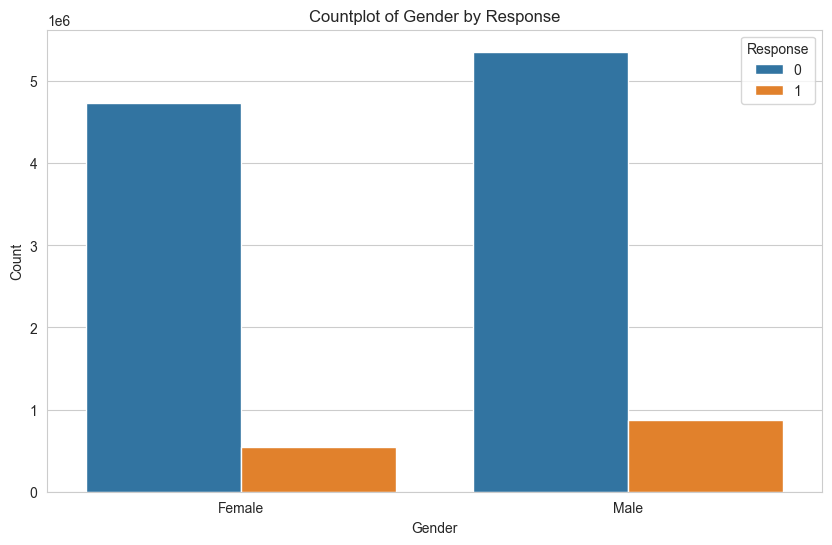

In [13]:
# 각 컬럼들의 Response 값에 따른 차이를 확인

# 'Age' 컬럼에 대한 boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Response', y='Age', data=train)
plt.title('Boxplot of Age by Response')
plt.xlabel('Response')
plt.ylabel('Age')
plt.show()

# 'Annual_Premium' 컬럼에 대한 boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Response', y='Annual_Premium', data=train)
plt.title('Boxplot of Annual Premium by Response')
plt.xlabel('Response')
plt.ylabel('Annual Premium')
plt.show()

# 'Vintage' 컬럼에 대한 boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Response', y='Vintage', data=train)
plt.title('Boxplot of Vintage by Response')
plt.xlabel('Response')
plt.ylabel('Vintage')
plt.show()

# 'Driving_License' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Driving_License', hue='Response', data=train)
plt.title('Countplot of Driving License by Response')
plt.xlabel('Driving License')
plt.ylabel('Count')
plt.show()

# 'Region_Code' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Region_Code', hue='Response', data=train)
plt.title('Countplot of Region Code by Response')
plt.xlabel('Region Code')
plt.ylabel('Count')
plt.show()

# 'Previously_Insured' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Previously_Insured', hue='Response', data=train)
plt.title('Countplot of Previously Insured by Response')
plt.xlabel('Previously Insured')
plt.ylabel('Count')
plt.show()

# 'Policy_Sales_Channel' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Policy_Sales_Channel', hue='Response', data=train)
plt.title('Countplot of Policy Sales Channel by Response')
plt.xlabel('Policy Sales Channel')
plt.ylabel('Count')
plt.show()

# 'Vehicle_Age' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Vehicle_Age', hue='Response', data=train)
plt.title('Countplot of Vehicle Age by Response')
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.show()

# 'Gender' 컬럼에 대한 countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Response', data=train)
plt.title('Countplot of Gender by Response')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()



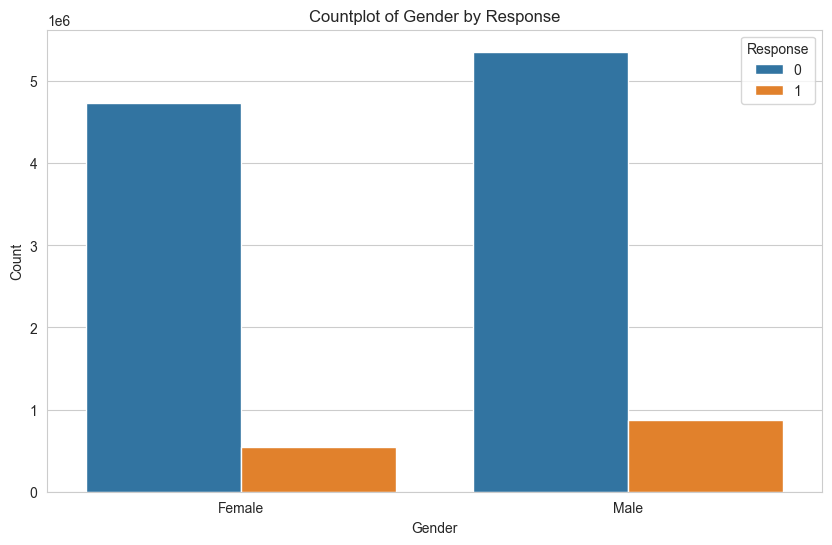

Response         0         1
Gender                      
Female    0.896703  0.103297
Male      0.860312  0.139688


In [17]:
# Gender에 따른 Response 차이 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Response', data=train)
plt.title('Countplot of Gender by Response')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Gender에 따른 Response 차이를 비율로 확인
gender_response_counts = train.groupby(['Gender', 'Response']).size().unstack()
gender_response_ratio = gender_response_counts.div(gender_response_counts.sum(axis=1), axis=0)
print(gender_response_ratio)


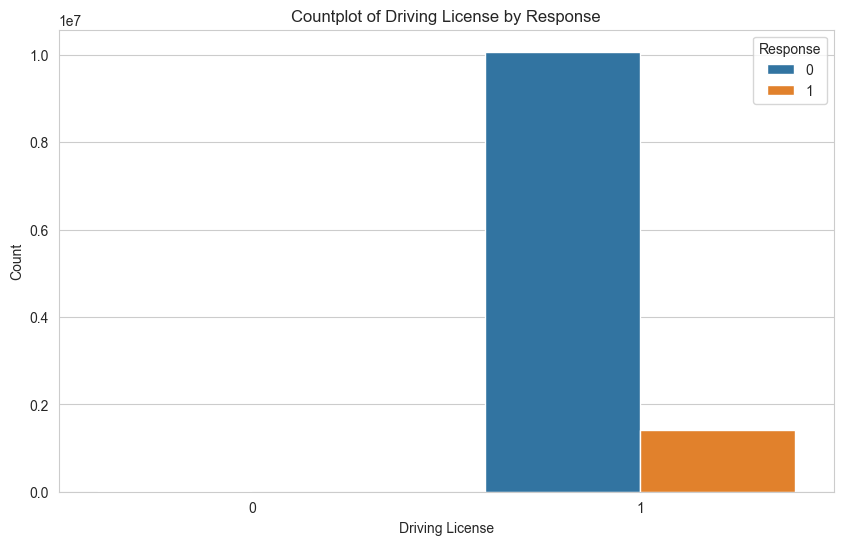

Response                0         1
Driving_License                    
0                0.944852  0.055148
1                0.876868  0.123132
Driving_License
1    11482041
0       22757
Name: count, dtype: int64


In [19]:
# Driving License에 따른 Response 차이 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='Driving_License', hue='Response', data=train)
plt.title('Countplot of Driving License by Response')
plt.xlabel('Driving License')
plt.ylabel('Count')
plt.show()

# Driving License에 따른 Response 차이를 비율로 확인
driving_license_response_counts = train.groupby(['Driving_License', 'Response']).size().unstack()
driving_license_response_ratio = driving_license_response_counts.div(driving_license_response_counts.sum(axis=1), axis=0)
print(driving_license_response_ratio)
print(train['Driving_License'].value_counts())


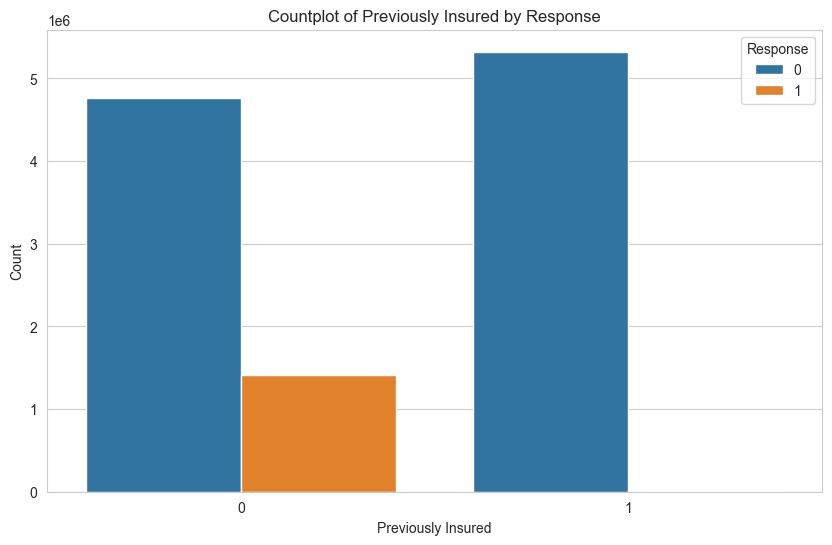

Response                   0         1
Previously_Insured                    
0                   0.771507  0.228493
1                   0.999362  0.000638


In [20]:
# Previously Insured에 따른 Response 차이 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='Previously_Insured', hue='Response', data=train)
plt.title('Countplot of Previously Insured by Response')
plt.xlabel('Previously Insured')
plt.ylabel('Count')
plt.show()

# Previously Insured에 따른 Response 차이를 비율로 확인
previously_insured_response_counts = train.groupby(['Previously_Insured', 'Response']).size().unstack()
previously_insured_response_ratio = previously_insured_response_counts.div(previously_insured_response_counts.sum(axis=1), axis=0)
print(previously_insured_response_ratio)


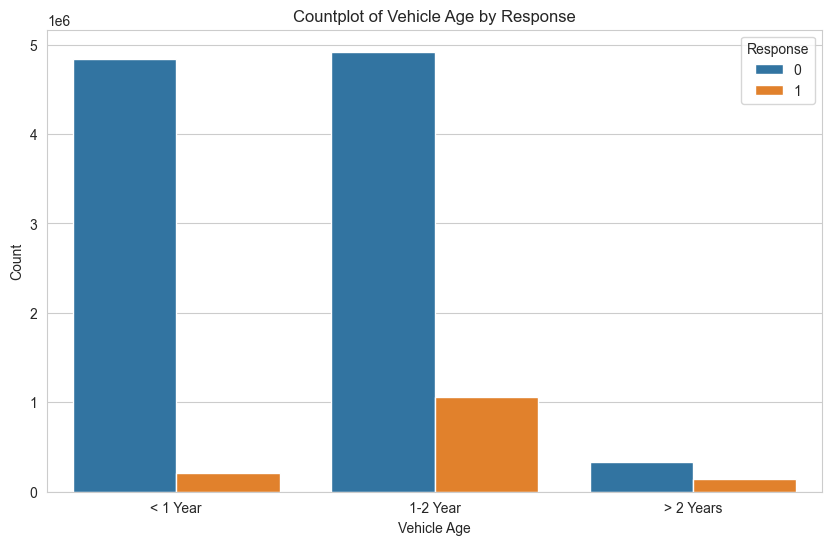

Response            0         1
Vehicle_Age                    
< 1 Year     0.958596  0.041404
1-2 Year     0.822275  0.177725
> 2 Years    0.700951  0.299049


In [21]:
# Vehicle_Age에 따른 Response 차이 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='Vehicle_Age', hue='Response', data=train)
plt.title('Countplot of Vehicle Age by Response')
plt.xlabel('Vehicle Age')
plt.ylabel('Count')
plt.show()

# Vehicle_Age에 따른 Response 차이를 비율로 확인
vehicle_age_response_counts = train.groupby(['Vehicle_Age', 'Response']).size().unstack()
vehicle_age_response_ratio = vehicle_age_response_counts.div(vehicle_age_response_counts.sum(axis=1), axis=0)
print(vehicle_age_response_ratio)


1. 알게된 정보
- Age가 높을 수록 Response가 1인 경우가 많음
    - 나이가 많을수록 보험에 대한 필요성이 커질 수 있으며, 반대로 젊은 층은 특정 금융 상품에 더 관심이 있을 수 있음
- Gender Response 비율: Female 0.10, Male 0.13
- Driving_License Response 비율: 0 0.05, 1 0.12
    - 운전면허 없는 사람이 극히 적음: 0 22757, 1 11482041
- Previously Insured가 1이면 Response가 1인 경우가 거의 없음
    - Response 비율: 0 0.2284, 1 0.0006
- Vehicle Age가 클 수록 Response 비율이 큼
    - Response 비율: < 1 Year 0.04, 1-2 Year 0.18, > Years 0.30
2. 추가로 확인이 필요한 정보

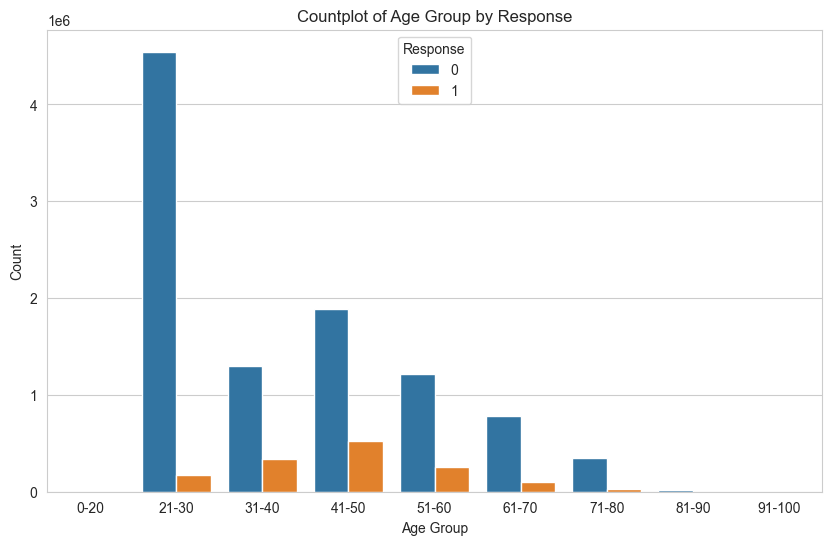

Response          0         1
Age_Group                    
0-20            NaN       NaN
21-30      0.962393  0.037607
31-40      0.796218  0.203782
41-50      0.783165  0.216835
51-60      0.824153  0.175847
61-70      0.888149  0.111851
71-80      0.937349  0.062651
81-90      0.954422  0.045578
91-100          NaN       NaN


In [22]:
# 나이를 그룹으로 나누어서 분석
# 나이 그룹 설정
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
train['Age_Group'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)

# 나이 그룹에 따른 Response 차이 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='Age_Group', hue='Response', data=train)
plt.title('Countplot of Age Group by Response')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

# 나이 그룹에 따른 Response 차이를 비율로 확인
age_group_response_counts = train.groupby(['Age_Group', 'Response']).size().unstack()
age_group_response_ratio = age_group_response_counts.div(age_group_response_counts.sum(axis=1), axis=0)
print(age_group_response_ratio)


In [25]:
from scipy.stats import chi2_contingency

# 나이 그룹과 Response 간의 카이제곱 검정
contingency_table = pd.crosstab(train['Age_Group'], train['Response'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi2: {chi2}, p-value: {p}')

Chi2: 667058.843256092, p-value: 0.0


In [35]:
from scipy.stats import chi2_contingency

# 새로운 데이터프레임 생성
df_insured_vintage = train.copy()

# Previously_Insured와 Vintage 변수의 데이터 타입을 변환
df_insured_vintage['Previously_Insured'] = df_insured_vintage['Previously_Insured'].astype(int)
df_insured_vintage['Vintage'] = df_insured_vintage['Vintage'].astype(int)

# Insured_Vintage 변수 생성
df_insured_vintage['Insured_Vintage'] = df_insured_vintage['Previously_Insured'] * df_insured_vintage['Vintage']

# Insured_Vintage에 따른 Response 차이를 비율로 확인
insured_vintage_response_counts = df_insured_vintage.groupby(['Insured_Vintage', 'Response']).size().unstack()
insured_vintage_response_ratio = insured_vintage_response_counts.div(insured_vintage_response_counts.sum(axis=1), axis=0)
print(insured_vintage_response_ratio)

# Insured_Vintage와 Response 간의 카이제곱 검정
contingency_table_iv = pd.crosstab(df_insured_vintage['Insured_Vintage'], df_insured_vintage['Response'])
chi2_iv, p_iv, dof_iv, expected_iv = chi2_contingency(contingency_table_iv)
print(f'Chi2: {chi2_iv}, p-value: {p_iv}')

Response                0         1
Insured_Vintage                    
0                0.771507  0.228493
10               0.999472  0.000528
11               0.998988  0.001012
12               0.998750  0.001250
13               0.999601  0.000399
...                   ...       ...
295              0.999211  0.000789
296              0.999536  0.000464
297              0.999863  0.000137
298              0.999575  0.000425
299              0.999238  0.000762

[291 rows x 2 columns]
Chi2: 1376757.7237271338, p-value: 0.0


In [34]:
sum(insured_vintage_response_ratio[1] > 0.01)

1

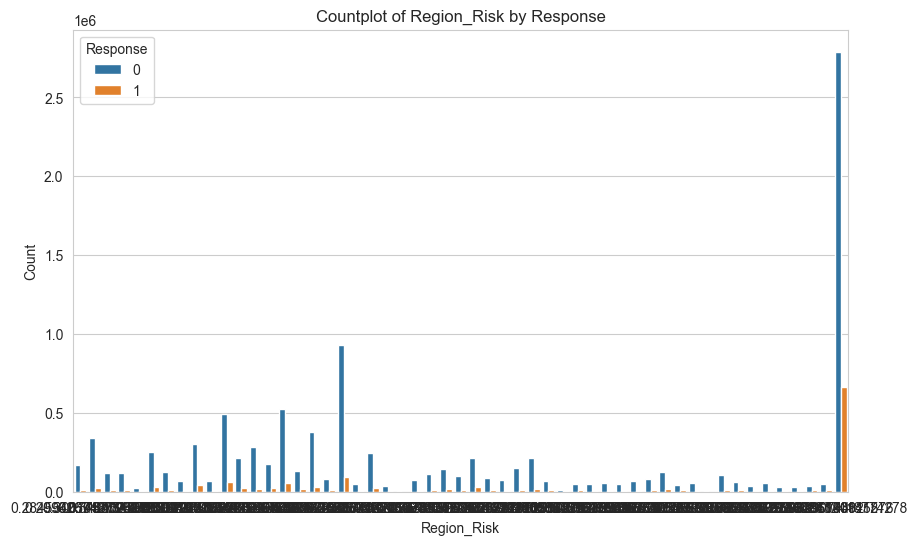

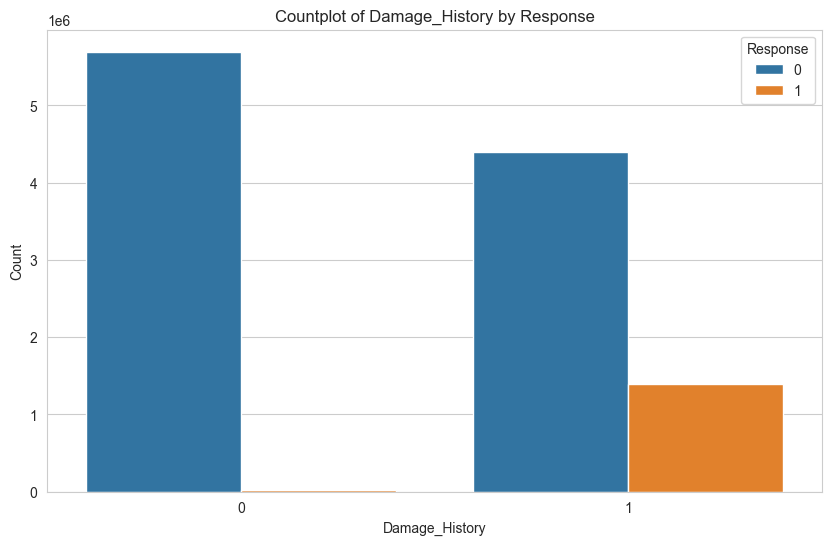

Region-Based Risk - Chi2: 260136.12571448286, p-value: 0.0
Vehicle Damage History - Chi2: 1489196.3454699982, p-value: 0.0


In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 새로운 데이터프레임 생성
df = train.copy()

# 데이터 타입 변환
df['Region_Code'] = df['Region_Code'].astype(int)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)

# Vehicle_Damage 변환: Yes -> 1, No -> 0
df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

# 1. Region-Based Risk 변수 생성
# 각 Region_Code 별 평균 Vehicle_Damage 비율을 계산하여 Region-Based Risk 변수 생성
region_risk = df.groupby('Region_Code')['Vehicle_Damage'].mean()
df['Region_Risk'] = df['Region_Code'].map(region_risk)

# 2. Vehicle Damage History 변수 생성
# 고객별로 Vehicle_Damage의 누적 합을 계산하여 Vehicle Damage History 변수 생성
df['Damage_History'] = df.groupby('id')['Vehicle_Damage'].cumsum()

# 파생 변수와 Response 간의 관계 시각화 및 카이제곱 검정

# Region-Based Risk
plt.figure(figsize=(10, 6))
sns.countplot(x='Region_Risk', hue='Response', data=df)
plt.title('Countplot of Region_Risk by Response')
plt.xlabel('Region_Risk')
plt.ylabel('Count')
plt.show()

# Vehicle Damage History
plt.figure(figsize=(10, 6))
sns.countplot(x='Damage_History', hue='Response', data=df)
plt.title('Countplot of Damage_History by Response')
plt.xlabel('Damage_History')
plt.ylabel('Count')
plt.show()

# 카이제곱 검정
def chi2_test(variable):
    contingency_table = pd.crosstab(df[variable], df['Response'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Region-Based Risk와 Response 간의 카이제곱 검정
chi2_risk, p_risk = chi2_test('Region_Risk')
print(f'Region-Based Risk - Chi2: {chi2_risk}, p-value: {p_risk}')

# Vehicle Damage History와 Response 간의 카이제곱 검정
chi2_damage, p_damage = chi2_test('Damage_History')
print(f'Vehicle Damage History - Chi2: {chi2_damage}, p-value: {p_damage}')


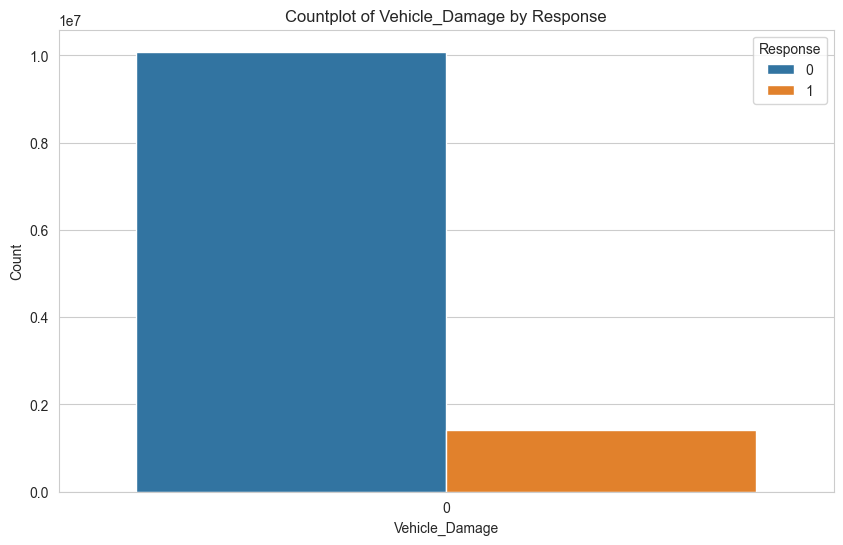

Vehicle_Damage - Chi2: 0.0, p-value: 1.0


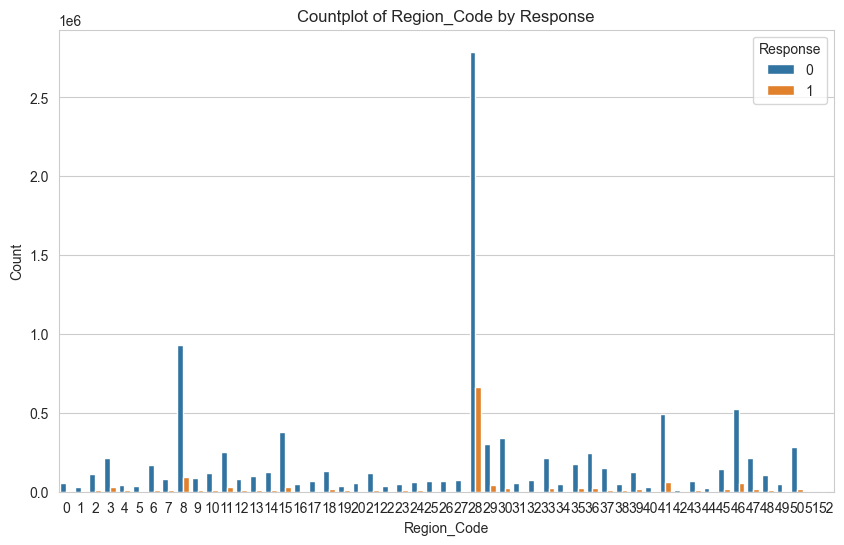

Region_Code - Chi2: 260136.12571448289, p-value: 0.0


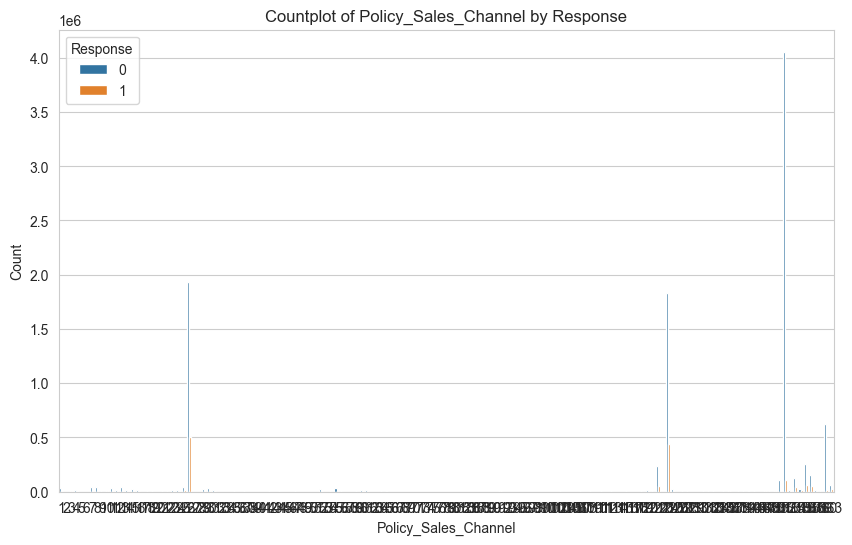

Policy_Sales_Channel - Chi2: 849225.8802792609, p-value: 0.0


In [51]:
# 데이터 타입 변환
df['Region_Code'] = df['Region_Code'].astype(int)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)

# Vehicle_Damage 변환: Yes -> 1, No -> 0
df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

# 1. Vehicle_Damage와 Response 간의 관계 분석
plt.figure(figsize=(10, 6))
sns.countplot(x='Vehicle_Damage', hue='Response', data=df)
plt.title('Countplot of Vehicle_Damage by Response')
plt.xlabel('Vehicle_Damage')
plt.ylabel('Count')
plt.show()

# Vehicle_Damage와 Response 간의 카이제곱 검정
contingency_table_vd = pd.crosstab(df['Vehicle_Damage'], df['Response'])
chi2_vd, p_vd, dof_vd, expected_vd = chi2_contingency(contingency_table_vd)
print(f'Vehicle_Damage - Chi2: {chi2_vd}, p-value: {p_vd}')

# 2. Region_Code와 Response 간의 관계 분석
plt.figure(figsize=(10, 6))
sns.countplot(x='Region_Code', hue='Response', data=df)
plt.title('Countplot of Region_Code by Response')
plt.xlabel('Region_Code')
plt.ylabel('Count')
plt.show()

# Region_Code와 Response 간의 카이제곱 검정
contingency_table_rc = pd.crosstab(df['Region_Code'], df['Response'])
chi2_rc, p_rc, dof_rc, expected_rc = chi2_contingency(contingency_table_rc)
print(f'Region_Code - Chi2: {chi2_rc}, p-value: {p_rc}')

# 3. Policy_Sales_Channel와 Response 간의 관계 분석
plt.figure(figsize=(10, 6))
sns.countplot(x='Policy_Sales_Channel', hue='Response', data=df)
plt.title('Countplot of Policy_Sales_Channel by Response')
plt.xlabel('Policy_Sales_Channel')
plt.ylabel('Count')
plt.show()

# Policy_Sales_Channel와 Response 간의 카이제곱 검정
contingency_table_psc = pd.crosstab(df['Policy_Sales_Channel'], df['Response'])
chi2_psc, p_psc, dof_psc, expected_psc = chi2_contingency(contingency_table_psc)
print(f'Policy_Sales_Channel - Chi2: {chi2_psc}, p-value: {p_psc}')

In [52]:
train['Vehicle_Damage'].value_counts()

Vehicle_Damage
Yes    5783229
No     5721569
Name: count, dtype: int64

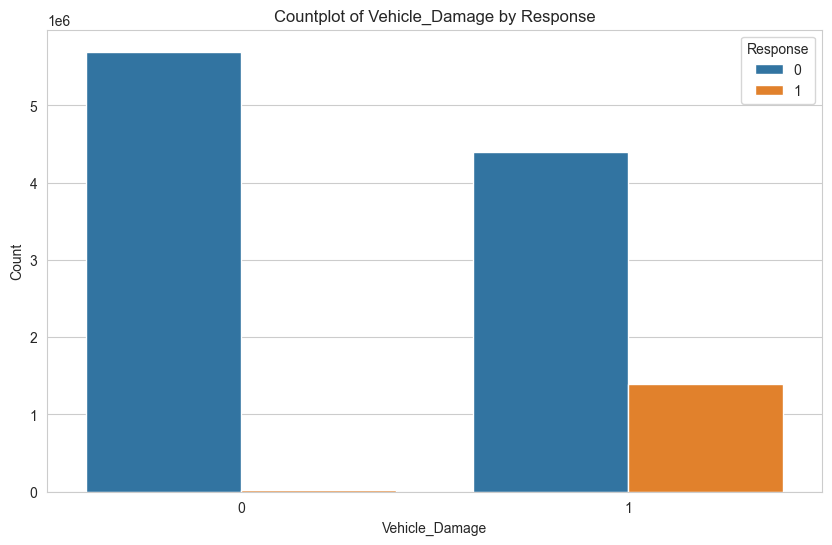

Vehicle_Damage - Chi2: 1489196.3454699982, p-value: 0.0


In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# 새로운 데이터프레임 생성
df = train.copy()

# Vehicle_Damage 변환: Yes -> 1, No -> 0
df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# Vehicle_Damage와 Response 간의 관계 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='Vehicle_Damage', hue='Response', data=df)
plt.title('Countplot of Vehicle_Damage by Response')
plt.xlabel('Vehicle_Damage')
plt.ylabel('Count')
plt.show()

# Vehicle_Damage와 Response 간의 카이제곱 검정
contingency_table_vd = pd.crosstab(df['Vehicle_Damage'], df['Response'])
chi2_vd, p_vd, dof_vd, expected_vd = chi2_contingency(contingency_table_vd)
print(f'Vehicle_Damage - Chi2: {chi2_vd}, p-value: {p_vd}')

In [54]:
# id와 response를 제외한 모든 컬럼에 대해서 response와의 유의미한 관계를 분석

# 분석할 컬럼 리스트
columns_to_analyze = [col for col in train.columns if col not in ['id', 'Response']]

# 각 컬럼에 대해 카이제곱 검정 수행
for column in columns_to_analyze:
    # 카테고리형 변수에 대해서만 카이제곱 검정 수행
    if train[column].dtype == 'object' or len(train[column].unique()) < 10:
        contingency_table = pd.crosstab(train[column], train['Response'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f'{column} - Chi2: {chi2}, p-value: {p}')
    else:
        # 연속형 변수에 대해서는 t-test 수행
        from scipy.stats import ttest_ind
        group0 = train[train['Response'] == 0][column]
        group1 = train[train['Response'] == 1][column]
        t_stat, p_val = ttest_ind(group0, group1)
        print(f'{column} - t-statistic: {t_stat}, p-value: {p_val}')


Gender - Chi2: 35070.87159196822, p-value: 0.0
Age - t-statistic: -417.38670662865786, p-value: 0.0
Driving_License - Chi2: 972.499672088707, p-value: 1.7058045796900096e-213
Region_Code - t-statistic: -43.47490174888443, p-value: 0.0
Previously_Insured - Chi2: 1376747.7298044744, p-value: 0.0
Vehicle_Age - Chi2: 614768.2061375531, p-value: 0.0
Vehicle_Damage - Chi2: 1489196.3454699982, p-value: 0.0
Annual_Premium - t-statistic: -109.4810491742203, p-value: 0.0
Policy_Sales_Channel - t-statistic: 524.2004036306735, p-value: 0.0
Vintage - t-statistic: 51.48342314376964, p-value: 0.0
Age_Group - Chi2: 667058.843256092, p-value: 0.0


In [55]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_Group
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0,21-30
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1,41-50
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0,21-30
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0,31-40
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0,31-40


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 13 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   Gender                category
 2   Age                   int64   
 3   Driving_License       category
 4   Region_Code           int32   
 5   Previously_Insured    category
 6   Vehicle_Age           category
 7   Vehicle_Damage        category
 8   Annual_Premium        float64 
 9   Policy_Sales_Channel  int32   
 10  Vintage               int64   
 11  Response              category
 12  Age_Group             category
dtypes: category(7), float64(1), int32(2), int64(3)
memory usage: 515.7 MB


In [61]:
import pandas as pd

# 데이터프레임 복사
df = train.copy()

# 데이터 타입 변환
df['Region_Code'] = df['Region_Code'].astype(int)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)

# Vehicle_Damage 변환: Yes -> 1, No -> 0
df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

In [62]:
df['Vehicle_Damage'].info(), df.head()

<class 'pandas.core.series.Series'>
RangeIndex: 11504798 entries, 0 to 11504797
Series name: Vehicle_Damage
Non-Null Count     Dtype
--------------     -----
11504798 non-null  int32
dtypes: int32(1)
memory usage: 43.9 MB


(None,
    id  Gender  Age Driving_License  Region_Code Previously_Insured  \
 0   0    Male   21               1           35                  0   
 1   1    Male   43               1           28                  0   
 2   2  Female   25               1           14                  1   
 3   3  Female   35               1            1                  0   
 4   4  Female   36               1           15                  1   
 
   Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
 0    1-2 Year               1         65101.0                   124      187   
 1   > 2 Years               1         58911.0                    26      288   
 2    < 1 Year               0         38043.0                   152      254   
 3    1-2 Year               1          2630.0                   156       76   
 4    1-2 Year               0         31951.0                   152      294   
 
   Response Age_Group  
 0        0     21-30  
 1        1     41-50  
 2   

In [64]:
import pandas as pd

# 데이터프레임 복사
df = train.copy()

# 데이터 타입 변환
df['Region_Code'] = df['Region_Code'].astype(int)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int)

# Vehicle_Damage 변환: Yes -> 1, No -> 0
df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

# 1. Insured_Vintage: Previously_Insured와 Vintage의 곱
df['Insured_Vintage'] = df['Previously_Insured'] * df['Vintage']

# 2. Damage_History: 고객별 누적 Vehicle_Damage
df['Damage_History'] = df.groupby('id')['Vehicle_Damage'].cumsum()

# 3. Region_Risk: 각 Region_Code 별 평균 Vehicle_Damage 비율
region_risk = df.groupby('Region_Code')['Vehicle_Damage'].mean()
df['Region_Risk'] = df['Region_Code'].map(region_risk)

# 4. Channel_Effectiveness: 각 Policy_Sales_Channel 별 Response 비율
channel_effectiveness = df.groupby('Policy_Sales_Channel')['Response'].mean()
df['Channel_Effectiveness'] = df['Policy_Sales_Channel'].map(channel_effectiveness)

# 결과 확인
print(df.head())


TypeError: Object with dtype category cannot perform the numpy op multiply